## Backpropagation implementation
Implementation of BP algorithm floating somewhere at the internet.

In [31]:
from __future__ import print_function
from __future__ import division

import numpy as np


def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x)) # logsig

def sigmoid_prime(x):
    return sigmoid(x)*(1.0-sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1.0 - x**2

def lin(x):
    return x


class NeuralNetwork:

    def __init__(self, layers, activation='tanh'):
        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_prime = sigmoid_prime
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_prime = tanh_prime

        # Set weights
        self.weights = []
        # layers = [2,2,1]
        # range of weight values (-1,1)
        # input and hidden layers - random((2+1, 2+1)) : 3 x 3
        for i in range(1, len(layers) - 1):
            r = 2*np.random.random((layers[i-1] + 1, layers[i] + 1)) -1
            self.weights.append(r)
        # output layer - random((2+1, 1)) : 3 x 1
        r = 2*np.random.random( (layers[i] + 1, layers[i+1])) - 1
        self.weights.append(r)

    # fits the network using backpropagation algorthm
    def fit(self, X, y, learning_rate=0.2, epochs=100000):
        # Add column of ones to X
        # This is to add the bias unit to the input layer
        ones = np.atleast_2d(np.ones(X.shape[0]))
        X = np.concatenate((ones.T, X), axis=1)
         
        for k in range(epochs):
            #if k % 10000 == 0: print('epochs:', k)
            
            i = np.random.randint(X.shape[0])
            a = [X[i]]

            for l in range(len(self.weights)):
                    dot_value = np.dot(a[l], self.weights[l])
                    activation = self.activation(dot_value)
                    a.append(activation)
            # output layer
            error = y[i] - a[-1]
            deltas = [error * self.activation_prime(a[-1])]

            # we need to begin at the second to last layer 
            # (a layer before the output layer)
            for l in range(len(a) - 2, 0, -1): 
                deltas.append(deltas[-1].dot(self.weights[l].T)*self.activation_prime(a[l]))

            # reverse
            # [level3(output)->level2(hidden)]  => [level2(hidden)->level3(output)]
            deltas.reverse()

            # backpropagation
            # 1. Multiply its output delta and input activation 
            #    to get the gradient of the weight.
            # 2. Subtract a ratio (percentage) of the gradient from the weight.
            for i in range(len(self.weights)):
                layer = np.atleast_2d(a[i])
                delta = np.atleast_2d(deltas[i])
                self.weights[i] += learning_rate * layer.T.dot(delta)
        
        return self.weights

    def predict(self, x): 
        a = np.concatenate((np.ones(1).T, np.array(x)), axis=0)      
        for l in range(0, len(self.weights)):
            a = self.activation(np.dot(a, self.weights[l]))
        return a
    
#     def predict(self, x):
#         x = np.array(x)
#         temp = np.ones(x.shape[0]+1)
#         temp[0:-1] = x
#         a = temp
#         for l in range(0, len(self.weights)):
#             a = self.activation(np.dot(a, self.weights[l]))
#         return a



## Constants + data generation
 Constants used in computations, read files with train + test data. Generation of the rest train data. Word transformations ("word" => bin).

In [32]:
# Some basic constants...
LETTERS = 25
MAX_WORD_LENGHT = 5
CHAR_BITS = 5 # Enough for 25 letters
#input_size = MAX_WORD_LENGHT * (len(bin(LETTERS))-2)

In [33]:
def transform_word(word):
    word = word.lower()
    bin_word = ''.join([bin(ord(x)-ord('a'))[2:].zfill(CHAR_BITS) for x in word])
    bin_word = bin_word + "1" * CHAR_BITS * (MAX_WORD_LENGHT - len(word))
    return list(map(int, bin_word))

def encode_unary(index, total_words):
    zeros = [0] * total_words
    zeros[index] = 1
    return zeros

In [34]:
f = "table.txt"
with open (f, "r") as file:
    raw_data = file.read().strip().split()

data = []
for word in raw_data:
    if (len(word) <= MAX_WORD_LENGHT and word not in data):
        data.append(word.lower())

table = [(transform_word(data[index]), encode_unary(index, len(data)), data[index]) for index in range(len(data))]
output_size = len(table)
print(table)


[([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0], [1, 0, 0, 0], 'lorem'), ([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0], [0, 1, 0, 0], 'ipsum'), ([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 1, 0], 'et'), ([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1], 'nulla')]


In [35]:
input_size = MAX_WORD_LENGHT * CHAR_BITS
hidden_sizes = [10]
layers = [input_size] + hidden_sizes + [output_size]

In [36]:
import string

def modify_word_random(word_to_modif):
    letter = np.random.choice(list(string.ascii_lowercase))
    word = list(word_to_modif)
    word[np.random.randint(len(word_to_modif))] = letter
    return ''.join(word)
    
def gen_word(similar_prob):
    if (np.random.uniform(0, 1) < similar_prob):
        index = np.random.randint(len(table))
        table_word = table[index][2]
        return transform_word(modify_word_random(table_word))
    else:
        return [np.random.randint(2) for _ in range(input_size)]

def generate_words(set_size, good_word_prob, similar_bad_word_prob=0.5):
    X = np.array([table[0][0]])
    y = np.array([table[0][1]])
    for _ in range(set_size - 1):
        if np.random.uniform(0, 1) < good_word_prob:
            index = np.random.randint(len(table))
            X = np.concatenate((X, [table[index][0]]))
            y = np.concatenate((y, [table[index][1]]))
        else:
            found = False
            while not found:
                found = True
                bad_word = gen_word(similar_bad_word_prob)
                if (bad_word in [x for (x, y, z) in table]):
                    found = False
                    continue
                if found:
                    X = np.concatenate((X, [bad_word]))
                    y = np.concatenate((y, [[0] * output_size]))
    return X, y

In [37]:
train_x, train_y = generate_words(set_size=50000, good_word_prob=0.5, similar_bad_word_prob=0.7)
train_x_good = []
train_y_good = []
train_x_bad = []
train_y_bad = []
for x, y in zip(train_x, train_y):
    if (1 in y):
        train_x_good.append(x)
        train_y_good.append(y)
    else:
        train_x_bad.append(x)
        train_y_bad.append(y)
        
train_x_good = np.array(train_x_good)
train_y_good = np.array(train_y_good)
train_x_bad = np.array(train_x_bad)
train_y_bad = np.array(train_y_bad)

In [38]:
f = "data.txt"
with open (f, "r") as file:
    raw_data = file.read().strip().split()

escape_chars = [".", ",", "!", "?", ";"]
    
data = []
for word in raw_data:
    if (len(word) <= MAX_WORD_LENGHT):
        w = word
        for i in range(len(escape_chars)):
            w = w.replace(escape_chars[i], "")

        if (w.isalpha):
            data.append(w.lower())
        

test_x = np.array([transform_word(w) for w in data])
test_y = np.array([[0] * len(table) for _ in range(len(test_x))])
test_z = np.array(data)

for i in range(len(test_x)):
    for j in range(len(table)):
        if (np.array_equal(table[j][0], test_x[i])):
            test_y[i] = table[j][1]
            

## Learning v1
Using backprop "hand" implementation

In [39]:
net = NeuralNetwork(layers, activation='tanh')
_ = net.fit(train_x, train_y, epochs=100000)
print("Fit complete")

Fit complete


In [40]:
def pretty_print(x, y, predicted_y, z):
    print(z.rjust(MAX_WORD_LENGHT), x, y, [float("%.3f" % value) for value in predicted_y])

# success of the net using MSE
def success(test_x, test_y):
    MSE = 0
    for (x, y) in zip(test_x, test_y):
        prediction = net.predict(x)
        MSE += sum((prediction - y) ** 2)
    return 1 - (MSE / (len(test_x) * output_size))
    
    
print(" word       --     word binary representation    --    desired output   --   real output")
print("========================================================================================")
show_max = 10
count = 0
for (x, y, z) in zip(test_x, test_y, test_z):
    pretty_print(x, y, net.predict(x), z)
    count += 1
    if (show_max == count):
        break
    

s = success(test_x, test_y)
print("Succ: ", s)
print("Err:  ", 1 - s)


 word       --     word binary representation    --    desired output   --   real output
lorem [0 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0] [1 0 0 0] [0.97, -0.005, 0.016, 0.035]
ipsum [0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 0 0 1 1 0 0] [0 1 0 0] [-0.028, 0.979, 0.018, 0.019]
dolor [0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 0 0 0 1] [0 0 0 0] [-0.032, -0.006, 0.007, 0.021]
  sit [1 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1] [0 0 0 0] [-0.034, -0.006, 0.005, 0.027]
 amet [0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1] [0 0 0 0] [-0.019, -0.011, 0.014, 0.03]
 elit [0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1] [0 0 0 0] [-0.02, -0.013, 0.017, 0.023]
  sed [1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1] [0 0 0 0] [-0.032, -0.004, 0.004, 0.021]
  vel [1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1] [0 0 0 0] [-0.034, -0.005, 0.007, 0.021]
donec [0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0] [0 0 0 0] [-0.016, -0.01, 0.015, 0.023]
 odio [0 1 1 1 0 0 0 0 1 1

## Learning v2
Using scikit-learn MLPClassifier

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
tolerance = 0.2

def round_prediction(y):
    result = []
    for i in range(len(y)):
        if (y[i] - tolerance <= 0):
            result.append(0)
        elif (y[i] + tolerance >= 1):
            result.append(1)
        else:
            return np.zeros(len(y))
    return result

def get_rounded_predictions(predictions):
    rounded_predictions = np.copy(predictions)
    for i in range(len(predictions)):
        rounded_predictions[i] = round_prediction(predictions[i])
    return rounded_predictions


C:\Anaconda2\envs\py3k\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Total iterations:  18
Score:  1.0


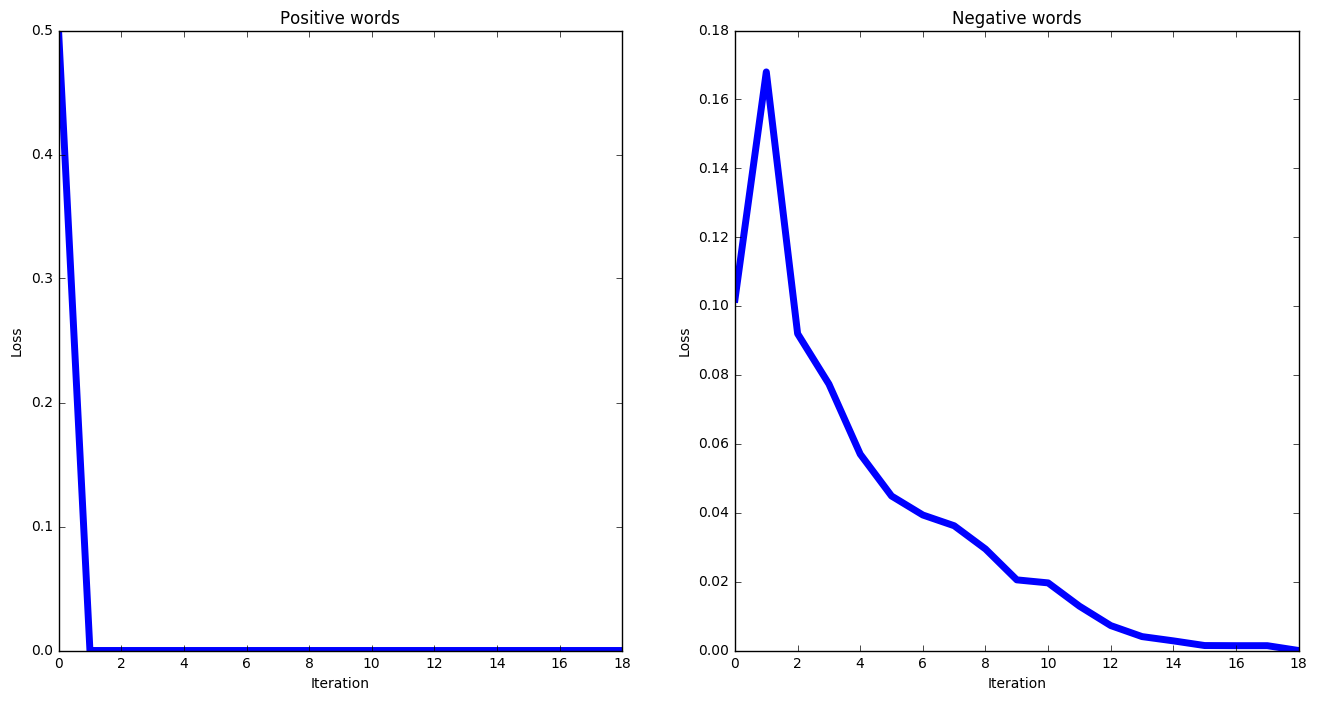

In [52]:
from sklearn import neural_network as nn
clf = nn.MLPClassifier(hidden_layer_sizes=(16, ),
                       activation='relu',
                       solver='adam',
                       alpha=0.0001,
                       shuffle=True,
                       verbose=False,
                       warm_start=True,
                       tol=0.00001,
                       max_iter=1,
                       learning_rate='constant',
                       learning_rate_init=0.001)

scores_good = []
scores_bad = []
for iteration in range(200):
    model = clf.fit(train_x, train_y)
    scores_good.append(1 - model.score(train_x_good, train_y_good))
    score = 1 - model.score(train_x_bad, train_y_bad)
    scores_bad.append(score)
    if score == 0:
        print("Total iterations: ", iteration)
        break
        
print("Score: ", model.score(test_x, test_y))        

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
#plt.semilogx(scores_good)
plt.plot(scores_good, linewidth=5)
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.title('Positive words')
plt.subplot(1,2,2)
#plt.semilogx(scores_bad)
plt.plot(scores_bad, linewidth=5)
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.title('Negative words')
plt.show()

predictions = model.predict_proba(test_x)


## Some other results...

In [53]:
table_test_x = []
table_test_y = []
for i in range(len(table)):
    table_test_x.append(table[i][0])
    table_test_y.append(table[i][1])
    
table_test_x = np.array(table_test_x)
table_test_y = np.array(table_test_y)

print("Score on table words: ", model.score(table_test_x, table_test_y))

Score on table words:  1.0


In [54]:
print(" WORD  ->  PREDICTED")
print("====================")

rounded_predictions = get_rounded_predictions(predictions)
mistakes = []
printed = 0
for i in range(len(test_x)):
    if not np.array_equal(rounded_predictions[i], test_y[i]):
        for j in range(len(table)):
            predicted_word = ""
            if (np.array_equal(table[j][1], rounded_predictions[i])):
                predicted_word = table[j][2]
                break
        #print(test_y[i], predictions[i])
        mistakes.append([test_z[i].rjust(MAX_WORD_LENGHT),
                         " -> ",
                         predicted_word,
                         "  ",
                         test_y[i],
                         " -> ",
                         [float("%.3f" % value) for value in predictions[i]]])

unique = []
for line in mistakes:
    line_str = ''.join([str(x) for x in line])
    if not line_str in unique:
        unique.append(line_str)
        print(line_str)

 WORD  ->  PREDICTED


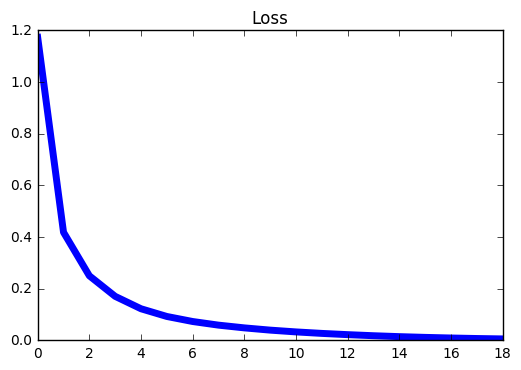

In [55]:
plt.plot(model.loss_curve_, linewidth=5)
plt.title("Loss")
plt.show()